# 파이토치 MNIST 모델

## modules import 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## 전처리 설정
- `transform.Compose`

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5, ), std=(0.5, ))])

## 데이터 로드 및 데이터 확인

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True, 
                                      download=True, 
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data', 
                                      train=False, 
                                      download=True, 
                                      transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = DataLoader(trainset, 
                          batch_size=128,
                          shuffle=True, 
                          num_workers=2)

test_loader = DataLoader(testset, 
                         batch_size=128,
                         shuffle=False,
                         num_workers=2)

In [5]:
image, label = next(iter(train_loader))

In [6]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [7]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

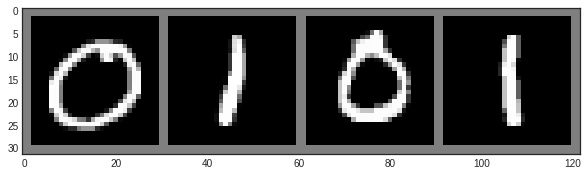

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [9]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [10]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [11]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.0888,  0.0431, -0.0718,  0.1476,  0.0565, -0.0184,  0.0655,  0.0456,
         -0.0407, -0.0244]], grad_fn=<AddmmBackward>)


## 손실함수와 옵티마이저

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [13]:
total_batch = len(train_loader)
print(total_batch)

469


- 설명을 위해 `epochs=2`로 지정

In [14]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print('Epoch: {}\tIter: {}\tLoss: {}'.format(epoch+1, i+1, running_loss/2000))
      running_loss = 0

Epoch: 1	Iter: 100	Loss: 0.11506081247329712
Epoch: 1	Iter: 200	Loss: 0.11480774331092834
Epoch: 1	Iter: 300	Loss: 0.11455830848217011
Epoch: 1	Iter: 400	Loss: 0.11424948310852051
Epoch: 2	Iter: 100	Loss: 0.11329655003547669
Epoch: 2	Iter: 200	Loss: 0.11221081900596619
Epoch: 2	Iter: 300	Loss: 0.1098723201751709
Epoch: 2	Iter: 400	Loss: 0.10356307560205459


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [15]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
net.parameters()

<generator object Module.parameters at 0x7fb764986570>

## 모델 테스트

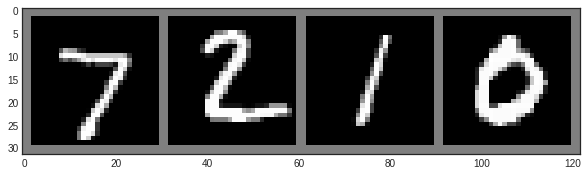

In [18]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [19]:
output = net(images)

In [20]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([3, 1, 8, 6, 1, 9, 6, 1, 8, 9, 9, 0, 8, 3, 9, 6, 3, 3, 8, 3, 1, 6, 6, 9,
        3, 6, 9, 0, 6, 9, 1, 3, 3, 8, 1, 3, 2, 6, 1, 3, 4, 6, 1, 8, 9, 4, 9, 6,
        4, 6, 8, 6, 9, 3, 8, 1, 4, 4, 2, 8, 9, 7, 0, 1, 6, 1, 6, 0, 9, 3, 8, 1,
        8, 0, 2, 1, 9, 9, 4, 6, 0, 3, 0, 6, 8, 6, 8, 1, 1, 3, 3, 9, 4, 1, 4, 1])


In [21]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

3	1	8	6	


In [22]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)


67.96


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

- 현재 GPU 설정

In [24]:
torch.cuda.is_available()

True

In [26]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [27]:
device

device(type='cuda')

- 데이터 로드


In [28]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5, ), std=(0.5, ))])

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True, 
                                      download=True, 
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data', 
                                      train=False, 
                                      download=True, 
                                      transform=transform)

train_loader = DataLoader(trainset, 
                          batch_size=128,
                          shuffle=True, 
                          num_workers=2)

test_loader = DataLoader(testset, 
                         batch_size=128,
                         shuffle=False,
                         num_workers=2)

- 모델 생성

In [29]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [30]:
net = Net().to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [32]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print('Epoch: {}\tIter: {}\tLoss: {}'.format(epoch+1, i+1, running_loss/2000))
      running_loss = 0

Epoch: 1	Iter: 100	Loss: 0.11494999611377717
Epoch: 1	Iter: 200	Loss: 0.11457396972179412
Epoch: 1	Iter: 300	Loss: 0.11416964256763458
Epoch: 1	Iter: 400	Loss: 0.1135564728975296
Epoch: 2	Iter: 100	Loss: 0.1114224112033844
Epoch: 2	Iter: 200	Loss: 0.10776750981807709
Epoch: 2	Iter: 300	Loss: 0.09686204028129577
Epoch: 2	Iter: 400	Loss: 0.0720635022521019


In [34]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)


77.82
